<a href="https://colab.research.google.com/github/Aweiss05/Market-Analytics/blob/main/Portfolio_Monte_Carlo_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

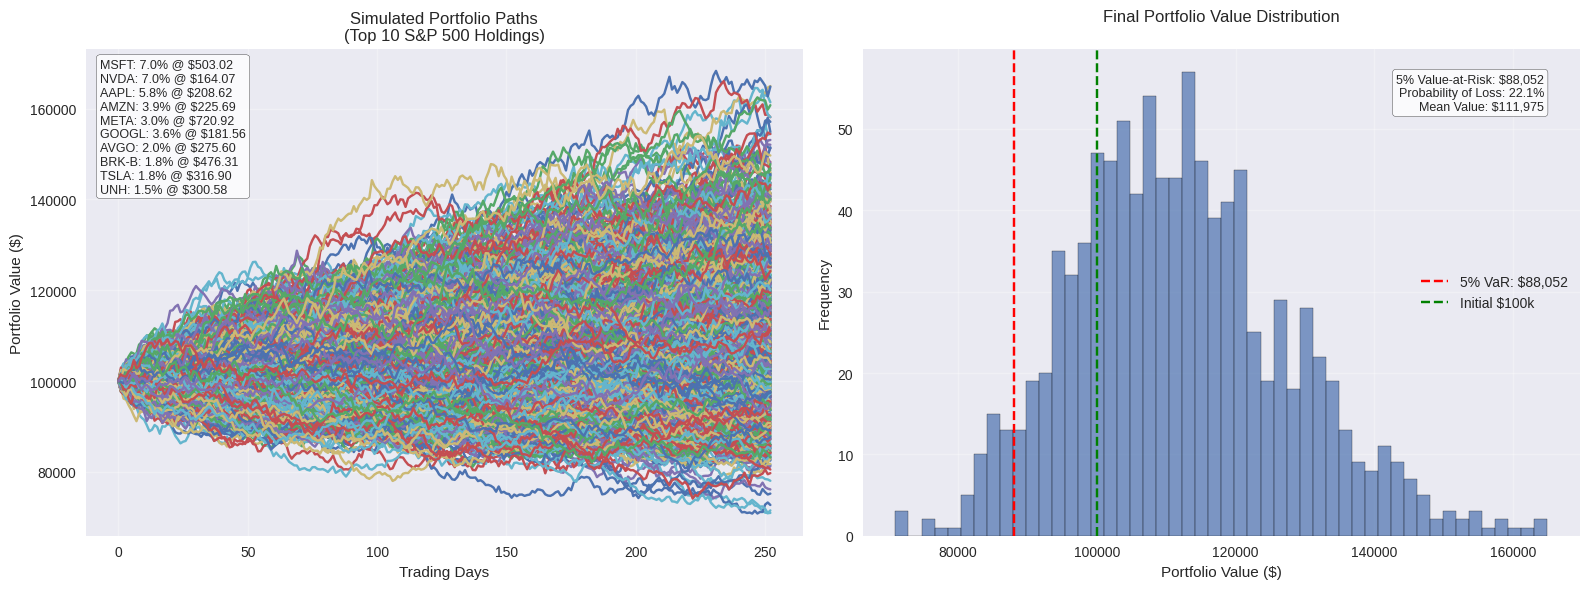

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Configure plot style
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Top 10 holdings of the S&P 500
tickers = ["MSFT", "NVDA", "AAPL", "AMZN", "META", "GOOGL", "AVGO", "BRK-B", "TSLA", "UNH"]
weights = np.array([0.07, 0.07, 0.058, 0.039, 0.03, 0.036, 0.02, 0.018, 0.018, 0.015])

# Current prices of stocks

prices = np.array([yf.Ticker(t).history(period="1d")["Close"].iloc[-1] for t in tickers])

# Simulation setup
mu = np.full(10, 0.10)
sigma = np.full(10, 0.20)
T = 1
N = 252
M = 1000
dt = T / N

# Correlation matrix
corr = np.full((10, 10), 0.3)
np.fill_diagonal(corr, 1.0)
cov = np.outer(sigma, sigma) * corr
L = np.linalg.cholesky(cov + np.eye(10)*0.01)  # regularized, ensuring positive

# Simulate price paths
price_paths = np.zeros((M, N+1, 10))
price_paths[:, 0, :] = prices

for sim in range(M):
    Z = np.random.normal(size=(N, 10))
    corrZ = Z @ L.T
    for t in range(1, N+1):
        price_paths[sim, t] = price_paths[sim, t-1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + np.sqrt(dt) * corrZ[t-1]
        )

# Portfolio value through time
portfolio = np.einsum('mtn,n->mt', price_paths, weights)
scale_factor = 100000 / np.dot(prices, weights)
portfolio *= scale_factor
final_values = portfolio[:, -1]

# Plotting Graphs
plt.figure()

# Graph 1: Simulated paths
plt.subplot(1, 2, 1)
for i in range(min(M, 1000)):
    plt.plot(portfolio[i])
plt.title("Simulated Portfolio Paths\n(Top 10 S&P 500 Holdings)")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value ($)")

# Holdings info
holdings_text = "\n".join(f"{t}: {w*100:.1f}% @ ${p:.2f}"
                          for t, w, p in zip(tickers, weights, prices))
plt.text(0.02, 0.98, holdings_text, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Graph 2: Distribution of outcomes
plt.subplot(1, 2, 2)
plt.hist(final_values, bins=50, edgecolor="black", alpha=0.7)
plt.title("Final Portfolio Value Distribution", pad=20)
plt.xlabel("Portfolio Value ($)")
plt.ylabel("Frequency")

VaR_5 = np.percentile(final_values, 5)
loss_prob = np.mean(final_values < 100000) * 100
plt.axvline(VaR_5, color='red', linestyle='--', label=f'5% VaR: ${VaR_5:,.0f}')
plt.axvline(100000, color='green', linestyle='--', label='Initial $100k')
plt.legend()

# Risk summary
stats_text = f"""5% Value-at-Risk: ${VaR_5:,.0f}
Probability of Loss: {loss_prob:.1f}%
Mean Value: ${np.mean(final_values):,.0f}"""
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         fontsize=9)

# Print side by side
plt.tight_layout()
plt.show()

